Carregando dataset...
Tokenizando dados...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Treinando Modelo: Com_PreTraining ---


Epoch,Training Loss,Validation Loss,Accuracy
1,0.321400,0.246047,0.913000
2,0.189400,0.251446,0.925000
3,0.133400,0.291703,0.921000
4,0.060500,0.343510,0.919000



--- Treinando Modelo: Sem_PreTraining ---


Epoch,Training Loss,Validation Loss,Accuracy
1,0.570000,0.362387,0.848500
2,0.323600,0.341288,0.862000
3,0.247600,0.391309,0.862000
4,0.166800,0.430956,0.867000


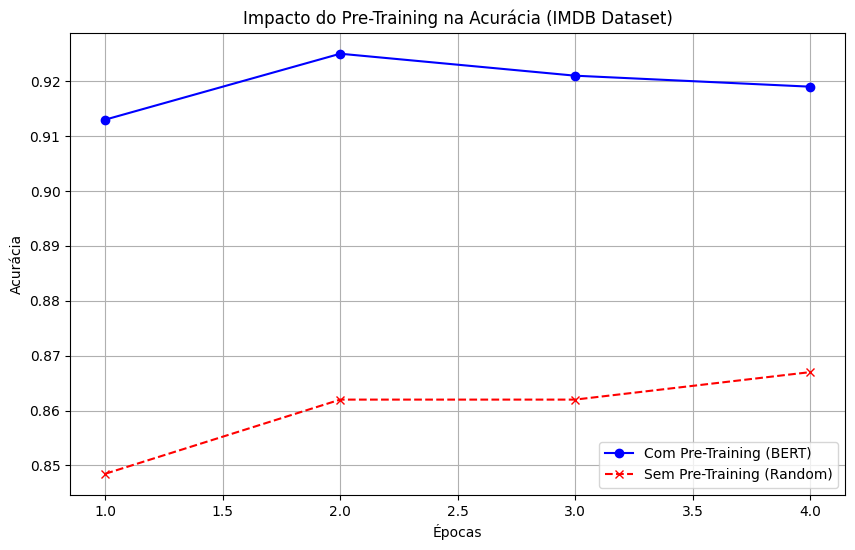

Acurácia Final Com Pre-Training: 0.9190
Acurácia Final Sem Pre-Training: 0.8670


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- 1. PREPARAÇÃO DOS DADOS ---
# Usando dataset IMDB (filmes) para classificação binária (positivo/negativo)
print("Carregando dataset...")
dataset = load_dataset("imdb")

small_train_dataset = dataset["train"].shuffle(seed=42).select([i for i in list(range(10000))])
small_test_dataset = dataset["test"].shuffle(seed=42).select([i for i in list(range(2000))])

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

print("Tokenizando dados...")
tokenized_train = small_train_dataset.map(tokenize_function, batched=True)
tokenized_test = small_test_dataset.map(tokenize_function, batched=True)

# Função de métricas para avaliação
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# --- 2. FUNÇÃO DE TREINAMENTO ---
def train_model(model, name):
    print(f"\n--- Treinando Modelo: {name} ---")

    training_args = TrainingArguments(
        output_dir=f"./results_{name}",
        num_train_epochs=4,
        per_device_train_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f'./logs_{name}',
        learning_rate=2e-5,
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Extrair histórico de acurácia
    history = trainer.state.log_history
    # O log também pode variar levemente a chave, vamos garantir que pegamos certo
    accuracies = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
    return accuracies

# --- 3. CONFIGURAÇÃO DOS MODELOS ---

# MODELO 1: COM PRE-TRAINING (Transfer Learning)
# Baixa os pesos já treinados na língua inglesa
model_pretrained = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# MODELO 2: SEM PRE-TRAINING (Random Init)
# Carrega apenas a arquitetura (config), mas inicializa pesos do zero
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
model_scratch = DistilBertForSequenceClassification(config)

# --- 4. EXECUÇÃO ---
acc_pretrained = train_model(model_pretrained, "Com_PreTraining")
acc_scratch = train_model(model_scratch, "Sem_PreTraining")

# --- 5. VISUALIZAÇÃO DOS RESULTADOS ---
epochs = range(1, len(acc_pretrained) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc_pretrained, 'b-o', label='Com Pre-Training (BERT)')
plt.plot(epochs, acc_scratch, 'r--x', label='Sem Pre-Training (Random)')
plt.title('Impacto do Pre-Training na Acurácia (IMDB Dataset)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

print(f"Acurácia Final Com Pre-Training: {acc_pretrained[-1]:.4f}")
print(f"Acurácia Final Sem Pre-Training: {acc_scratch[-1]:.4f}")

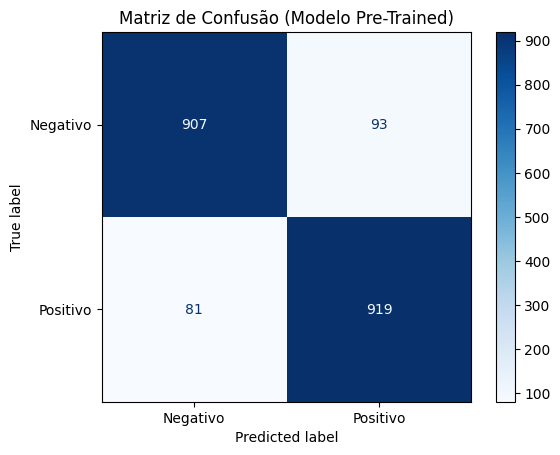

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gera previsões finais com o melhor modelo
trainer_pretrained = Trainer(model=model_pretrained)
preds = trainer_pretrained.predict(tokenized_test)
y_pred = preds.predictions.argmax(-1)
y_true = preds.label_ids

# Plota
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Positivo"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão (Modelo Pre-Trained)")
plt.show()